## Preprocessing and merging

In [1]:
import warnings
warnings.filterwarnings("ignore")
import muon as mu
import numpy as np
import scanpy as sc
import scirpy as ir
from cycler import cycler
from matplotlib import cm as mpl_cm
from matplotlib import pyplot as plt
from mudata import MuData
import anndata
import pandas as pd

In [2]:
%cd data

E:\Python code\Machine learning\JupyterNote\Biology\scripy\data


In [3]:
%pwd

'E:\\Python code\\Machine learning\\JupyterNote\\Biology\\scripy\\data'

In [4]:
adata_gex = sc.read("all_gex.h5ad")
adata_tcr = sc.read("all_tcr.h5ad")
mdata = mu.MuData({"gex": adata_gex, "airr": adata_tcr})
mdata

MuData object with n_obs × n_vars = 106435 × 33708
  2 modalities
    gex:	106435 x 33708
      obs:	'mouse_id', 'date', 'tissue'
    airr:	77660 x 0
      obsm:	'airr'

In [6]:
# Extract sample information and add to `mdata.obs`
mdata.obs["sample"] = mdata.obs.index.to_series().str.rsplit("_", n=2).str[-1] + "_" + mdata.obs.index.to_series().str.rsplit("_", n=2).str[-2]
# only two samples
# mdata.obs["sample"] = mdata.obs.index.to_series().str.rsplit("_", n=2).str[-2] + "_" + mdata.obs.index.to_series().str.rsplit("_", n=2).str[-1]

mdata.obs

gex:mouse_id gex:date gex:tissue    sample
AAACCAAAGGGGAGCT-1_0516_CNS       CMO318     0516         CN  CNS_0516
AAACCAAAGGTCGACT-1_0516_CNS       CMO325     0516         CN  CNS_0516
AAACCAGCACGTAAAG-1_0516_CNS       CMO318     0516         CN  CNS_0516
AAACCATTCACTACTC-1_0516_CNS       CMO325     0516         CN  CNS_0516
AAACCATTCCTCCGGT-1_0516_CNS       CMO325     0516         CN  CNS_0516
...                                  ...      ...        ...       ...
GTTGTGGGTGGATCGC-1_0605_SPL       CMO304     0605         SP  SPL_0605
GTTGTGGGTGGCTGTA-1_0605_SPL       CMO301     0605         SP  SPL_0605
GTTGTGGGTGGTCCCC-1_0605_SPL       CMO301     0605         SP  SPL_0605
GTTGTGGGTGTCCCTG-1_0605_SPL       CMO302     0605         SP  SPL_0605
GTTGTGGGTGTTACCC-1_0605_SPL       CMO301     0605         SP  SPL_0605

[106435 rows x 4 columns]

In [7]:

import pandas as pd
metadata_paths = {
    "CNS": "CNS_cell_type_annotation.csv",
    "SPL": "Spleen_cell_type_annotation.csv"
}

# Read metadata files
metadata_list = []
for tissue, path in metadata_paths.items():
    meta = pd.read_csv(path, index_col=0)  # Ensure the first column is treated as the index

    # Extract run number from the index (barcode) → `_1` means "0516", `_2` means "0605"
    meta["run_num"] = meta.index.to_series().str.split("_").str[-1].map({"1": "0516", "2": "0605"})

    # Create the correct barcode format: "AAACCAAAGGGGAGCT-1_CNS_0605"
    meta["barcode"] = meta.index.to_series().str.replace("_1", "", regex=False).str.replace("_2", "", regex=False)
    meta["barcode"] = meta["barcode"] + "_" + meta["run_num"] + "_" + tissue

    metadata_list.append(meta)

# Combine metadata from both CNS and Spleen
metadata = pd.concat(metadata_list, ignore_index=False)  # Keep original index

# Merge metadata with `mdata.obs`
mdata.obs = mdata.obs.merge(metadata, left_index=True, right_on="barcode", how="left")

# Set the index to the barcode column for consistency
mdata.obs.set_index("barcode", inplace=True)

## Get common cell indices between gex and airr

In [8]:
common_cells = mdata.mod["gex"].obs.index.intersection(mdata.mod["airr"].obs.index)

# Subset gex to only include these cells
gex_subset = mdata.mod["gex"][common_cells, :].copy()
tcr_subset = mdata.mod["airr"][common_cells, :].copy()
# Create a new MuData object to preserve alignment
mdata_new = mu.MuData({"gex": gex_subset, "airr": tcr_subset})

# Copy previous metadata from the old mdata object
mdata_new.obs = mdata.obs.loc[mdata_new.mod["gex"].obs.index]

# Verify the new object
print(mdata_new)

MuData object with n_obs × n_vars = 77660 × 33708
  obs:	'sample', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mt', 'integrated_nn_res.2', 'seurat_clusters', 'level_2_clusters', 'manual_cell_type', 'run_num'
  2 modalities
    gex:	77660 x 33708
      obs:	'mouse_id', 'date', 'tissue'
    airr:	77660 x 0
      obsm:	'airr'


In [9]:
# mdata_new.write("all_integrated_mdata_with_TCR.h5mu")

In [10]:
types = mdata_new.obs['manual_cell_type']
category_counts = types.value_counts()
category_counts


manual_cell_type
CD4+ T       19856
CD8+ T       16845
multiplet    11634
Treg          6861
Myeloid       2737
Name: count, dtype: int64

## Brief gene expression analysis on all the cells in two experimental runs

In [11]:
import matplotlib.pyplot as plt
import numpy as np

In [12]:
mdata = mu.read("all_integrated_mdata_with_TCR.h5mu")
mdata

MuData object with n_obs × n_vars = 77660 × 33708
  obs:	'sample', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mt', 'integrated_nn_res.2', 'seurat_clusters', 'level_2_clusters', 'manual_cell_type', 'run_num'
  2 modalities
    gex:	77660 x 33708
      obs:	'mouse_id', 'date', 'tissue'
    airr:	77660 x 0
      obsm:	'airr'

In [13]:
# Count non-NA rows by sample
non_na_counts = mdata.obs.dropna().groupby("sample").size()
non_na_counts


sample
CNS_0516      233
CNS_0605    13944
SPL_0516    15442
SPL_0605    28314
dtype: int64

In [14]:
sc.pp.log1p(mdata["gex"])
sc.pp.pca(mdata["gex"], svd_solver="arpack")
sc.pp.neighbors(mdata["gex"])
sc.tl.umap(mdata["gex"])

In [15]:
ir.pp.index_chains(mdata)
ir.tl.chain_qc(mdata)

In [16]:
# what can be used as 'color'
print(mdata.var_names)
print(mdata.obs.columns)

Index(['Xkr4', 'Gm1992', 'Gm19938', 'Gm37381', 'Rp1', 'Sox17', 'Gm37587',
       'Gm37323', 'Mrpl15', 'A930006A01Rik',
       ...
       'CMO303', 'CMO304', 'CMO305', 'CMO317', 'CMO318', 'CMO325', 'CMO326',
       'CMO321', 'CMO322', 'CMO323'],
      dtype='object', length=33708)
Index(['gex:mouse_id', 'gex:date', 'gex:tissue', 'sample', 'orig.ident',
       'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID',
       'HTO_secondID', 'HTO_margin', 'HTO_classification',
       'HTO_classification.global', 'hash.ID', 'percent.mt',
       'integrated_nn_res.2', 'seurat_clusters', 'level_2_clusters',
       'manual_cell_type', 'run_num', 'airr:receptor_type',
       'airr:receptor_subtype', 'airr:chain_pairing'],
      dtype='object')


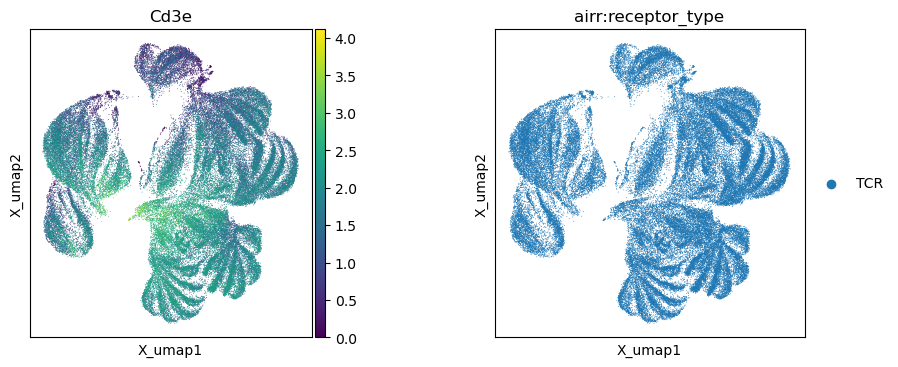

In [17]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={"wspace": 0.5})
mu.pl.embedding(mdata, basis="gex:umap", color=["Cd3e"], ax=ax0, show=False)
mu.pl.embedding(mdata, basis="gex:umap", color=["airr:receptor_type"], ax=ax1)

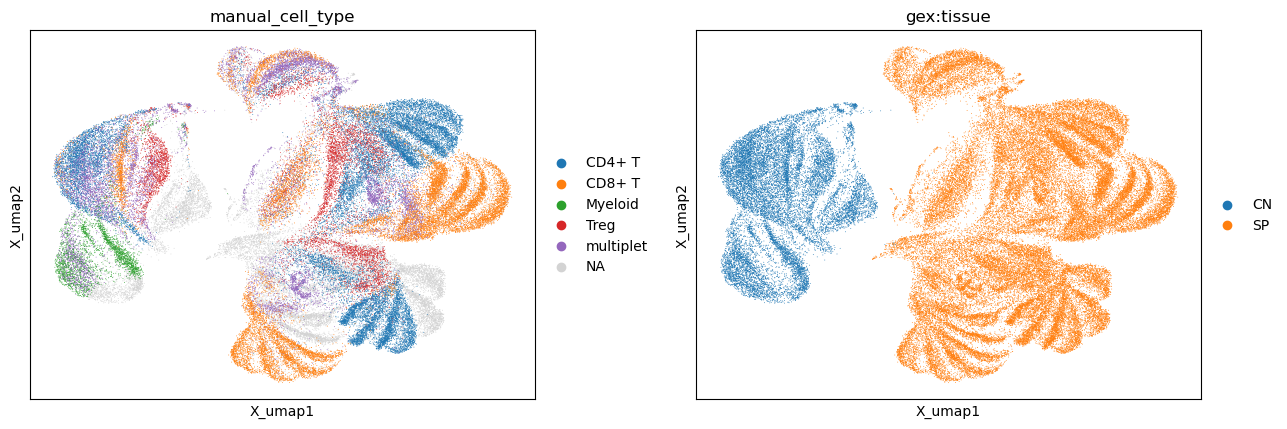

In [18]:
mu.pl.embedding(mdata, basis="gex:umap", color=['manual_cell_type','gex:tissue'],wspace = 0.2)

### Large batch effect - only keep 0605 for TCR sequence analysis and cell types in ["CD4+ T", "Treg", "CD8+ T"] for now

This should be carefully considered

In [19]:
mdata

MuData object with n_obs × n_vars = 77660 × 33708
  obs:	'sample', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mt', 'integrated_nn_res.2', 'seurat_clusters', 'level_2_clusters', 'manual_cell_type', 'run_num'
  2 modalities
    gex:	77660 x 33708
      obs:	'mouse_id', 'date', 'tissue'
      uns:	'log1p', 'pca', 'neighbors', 'umap', 'airr:receptor_type_colors', 'manual_cell_type_colors', 'gex:tissue_colors'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'distances', 'connectivities'
    airr:	77660 x 0
      obs:	'receptor_type', 'receptor_subtype', 'chain_pairing'
      uns:	'chain_indices'
      obsm:	'airr', 'chain_indices'

## drop Treg transfer samples

In [20]:
# Drop NaN rows in obs and subset mdata
# print(mdata.obs['sample'])
D2_samples = ["CMO301", "CMO302", "CMO318", "CMO325"]
D2_data = ["0516"]

mdata = mdata[~ (mdata.mod["gex"].obs["mouse_id"].isin(D2_samples) & mdata.mod["gex"].obs["date"].isin(D2_data))]
mdata

View of MuData object with n_obs × n_vars = 65203 × 33708
  obs:	'sample', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mt', 'integrated_nn_res.2', 'seurat_clusters', 'level_2_clusters', 'manual_cell_type', 'run_num'
  2 modalities
    gex:	65203 x 33708
      obs:	'mouse_id', 'date', 'tissue'
      uns:	'log1p', 'pca', 'neighbors', 'umap', 'airr:receptor_type_colors', 'manual_cell_type_colors', 'gex:tissue_colors'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'distances', 'connectivities'
    airr:	65203 x 0
      obs:	'receptor_type', 'receptor_subtype', 'chain_pairing'
      uns:	'chain_indices'
      obsm:	'airr', 'chain_indices'

In [21]:
# mu.pp.filter_obs(mdata, "sample", lambda x: np.isin(x, ["CNS_0605", "SPL_0605"]))
# mu.pp.filter_obs(mdata, "manual_cell_type", lambda x: np.isin(x, ["CD4+ T", "Treg", "CD8+ T"]))

# selected_samples = ["CNS_0605", "SPL_0605"]  # List of categories to keep
# mdata_subset = mdata[mdata.obs["sample"].isin(selected_samples)].copy()
# mdata = mdata_subset

mdata.obs["sample"] = mdata.obs["sample"].cat.remove_unused_categories()
mdata.obs["manual_cell_type"] = mdata.obs["manual_cell_type"].cat.remove_unused_categories()
mdata.obs["celltype_sample"] = (
    mdata.obs["manual_cell_type"].astype(str) + "_" + mdata.obs["sample"].astype(str)
)


In [22]:
mdata.obs["celltype_sample"]

AAACGGAGTCTACGGA-1_0516_CNS      Myeloid_CNS_0516
AAAGCGTAGGCAACGA-1_0516_CNS          nan_CNS_0516
AACCACTCAATGGTCT-1_0516_CNS    multiplet_CNS_0516
AACCAGACACGGCAAG-1_0516_CNS    multiplet_CNS_0516
AAGGTGTAGCCCAACG-1_0516_CNS       CD4+ T_CNS_0516
                                      ...        
GTTGTGGGTGGAGCGA-1_0605_SPL         Treg_SPL_0605
GTTGTGGGTGGATCGC-1_0605_SPL       CD8+ T_SPL_0605
GTTGTGGGTGGCTGTA-1_0605_SPL       CD8+ T_SPL_0605
GTTGTGGGTGTCCCTG-1_0605_SPL       CD4+ T_SPL_0605
GTTGTGGGTGTTACCC-1_0605_SPL       CD4+ T_SPL_0605
Name: celltype_sample, Length: 65203, dtype: object

### Additional prefiltering - filter out "orphan VDJ", "orphan VJ"

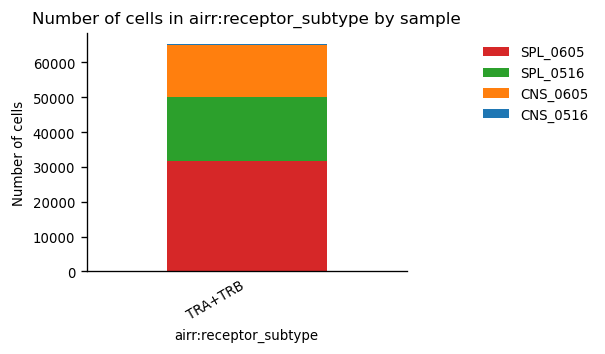

In [23]:
_ = ir.pl.group_abundance(mdata, groupby="airr:receptor_subtype", target_col="sample")

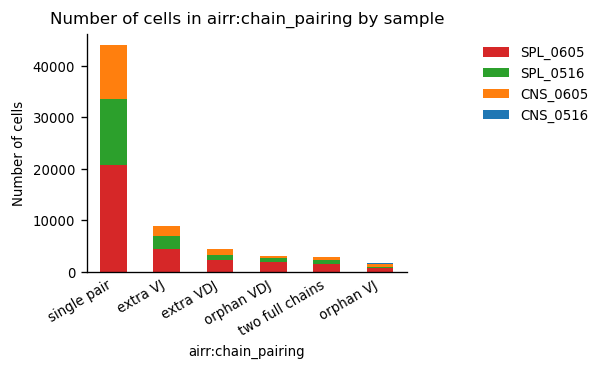

In [24]:
_ = ir.pl.group_abundance(mdata, groupby="airr:chain_pairing", target_col="sample")

In [25]:
print(
    "Fraction of cells with more than one pair of TCRs: {:.2f}".format(
        np.sum(mdata.obs["airr:chain_pairing"].isin(["extra VJ", "extra VDJ", "two full chains", "multichain"]))
        / mdata["airr"].n_obs
    )
)

Fraction of cells with more than one pair of TCRs: 0.25


In [26]:
mu.pp.filter_obs(mdata, "airr:chain_pairing", lambda x: ~np.isin(x, []))
mdata.mod["airr"].obs["chain_pairing"]

selected_chains = ["orphan VDJ", "orphan VJ"]  # List of categories to keep
mdata_filtered = mdata[~mdata.mod["airr"].obs["chain_pairing"].isin(selected_chains)].copy()


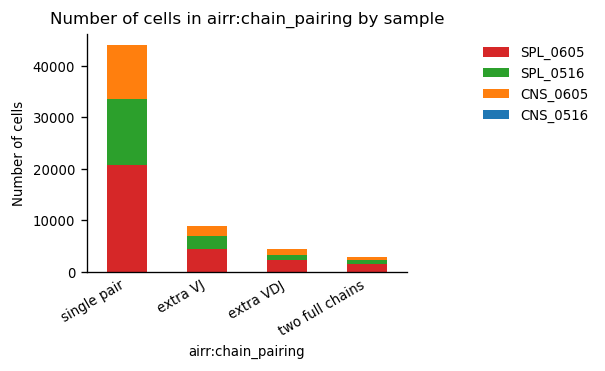

In [27]:
ax = ir.pl.group_abundance(mdata_filtered, groupby="airr:chain_pairing", target_col="sample")

## Clonotype

### Apply TCRDist for clusering the TCRs and also obtain clonotype_network

In [28]:
# using default parameters, `ir_dist` will compute nucleotide sequence identity
ir.pp.ir_dist(mdata)
# metric = 'tcrdist'
ir.tl.define_clonotypes(mdata, receptor_arms="all", dual_ir="primary_only")

In [29]:
ir.tl.clonotype_network(mdata, min_cells=10)

In [30]:
#_ = ir.pl.clonotype_network(mdata, color="sample", base_size=20, label_fontsize=9, panel_size=(10,10))

In [31]:
## recompute clonotype

ir.pp.ir_dist(
    mdata,
    metric="tcrdist",
    sequence="aa",
    cutoff=15,
)

In [32]:
ir.tl.define_clonotype_clusters(mdata, sequence="aa", metric="tcrdist", receptor_arms="all", dual_ir="any")

In [33]:
ir.tl.clonotype_network(mdata, min_cells=10, sequence="aa", metric="tcrdist")

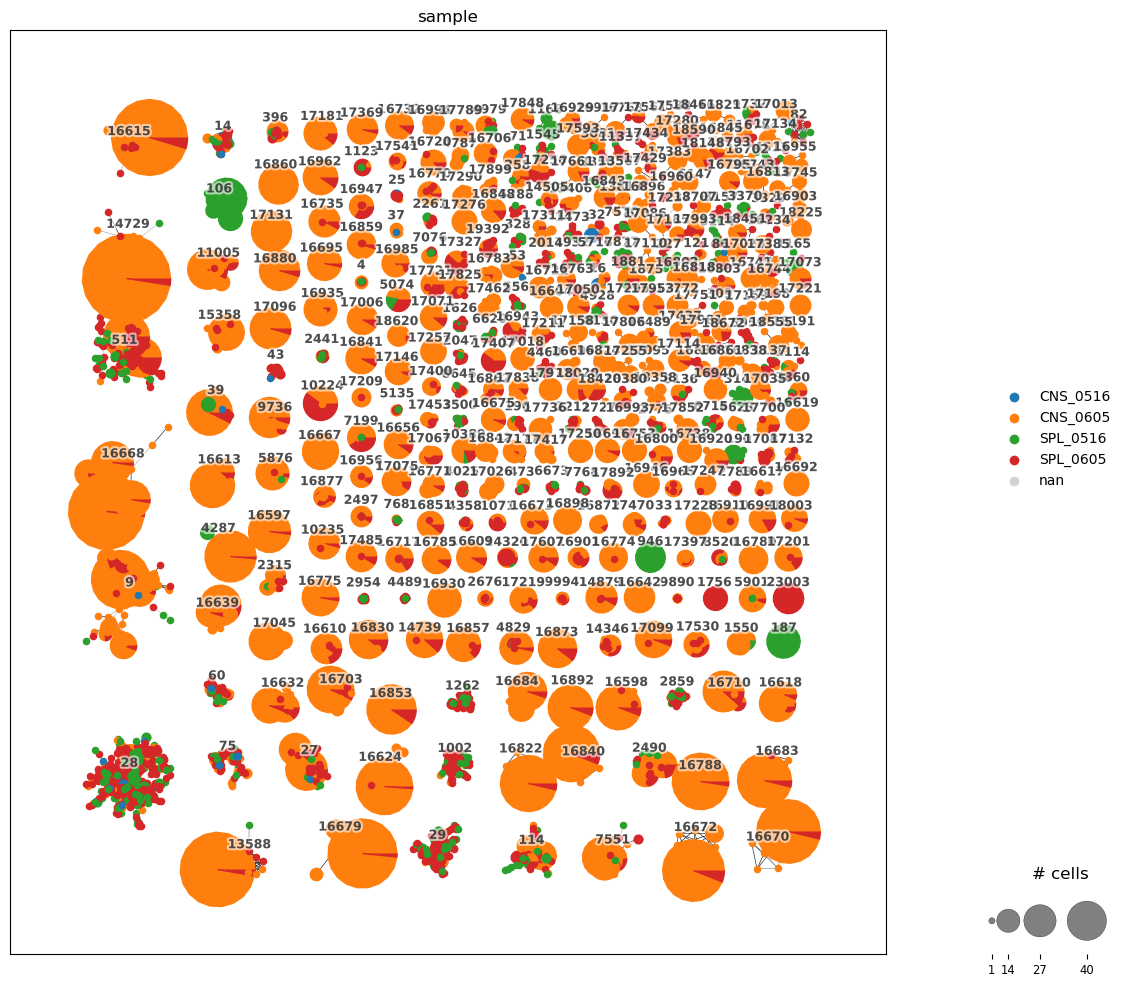

In [34]:
_ = ir.pl.clonotype_network(mdata, color="sample", label_fontsize=9, panel_size=(12, 12), base_size=20)

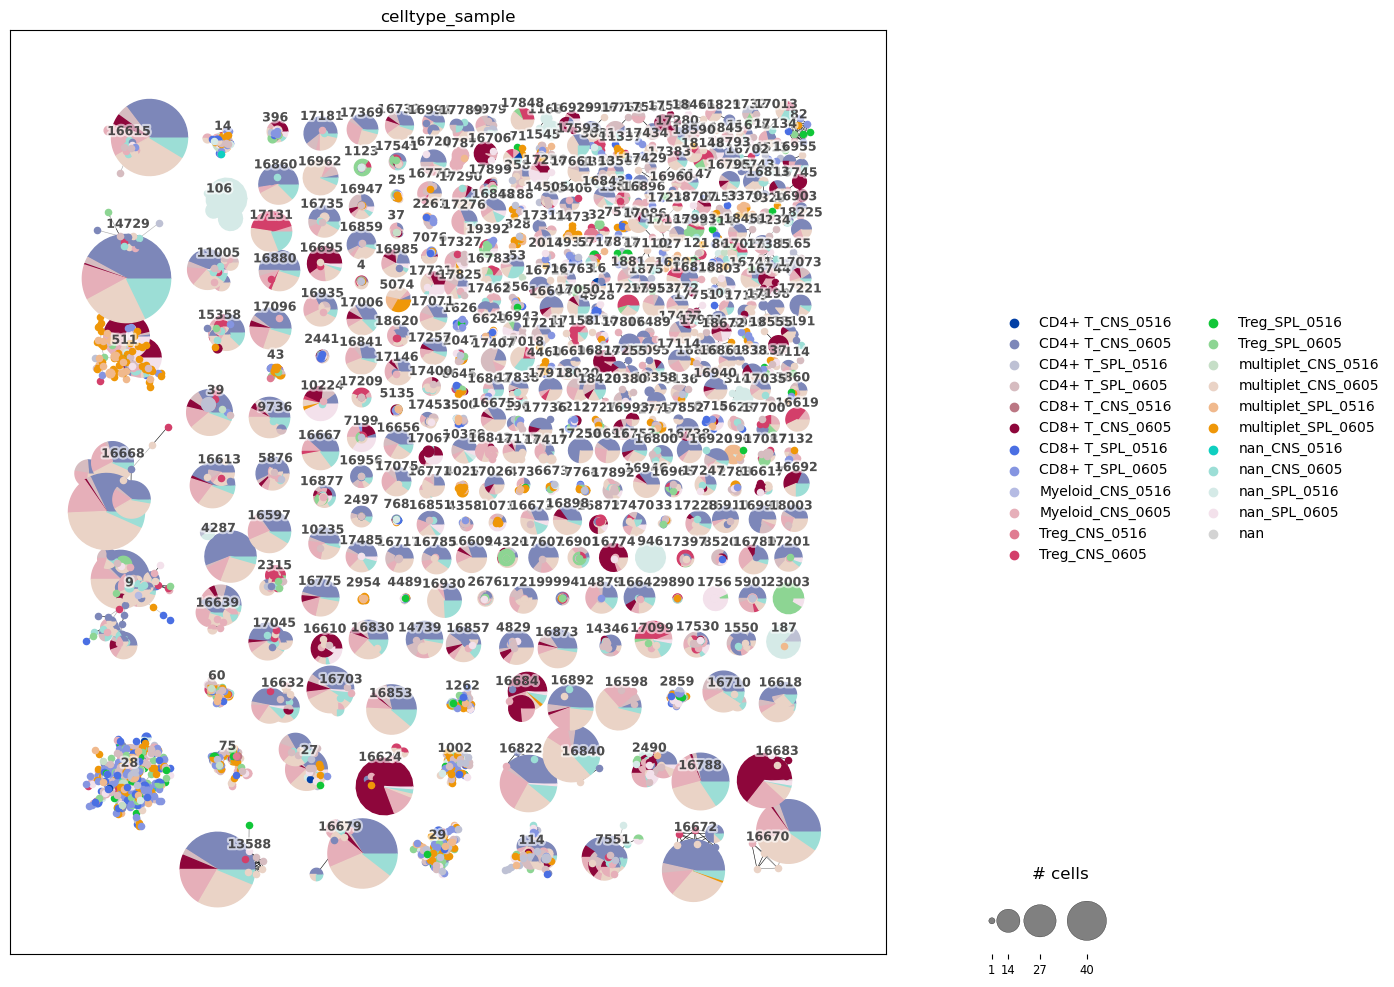

In [35]:
_ = ir.pl.clonotype_network(mdata, color="celltype_sample", label_fontsize=9, panel_size=(12, 12), base_size=20)


### Clonotype modularity

The clonotype modularity measures how densely connected the transcriptomics neighborhood graph underlying the cells in a clonotype is. Clonotypes with a high modularity consist of cells that are **transcriptionally more similar** than that of a clonotype with a low modularity. CNS has higher clonotype modularity than spleen.

In [36]:
#
ir.tl.clonotype_modularity(mdata, target_col="airr:cc_aa_tcrdist")

100%|██████████| 1000/1000 [01:28<00:00, 11.33it/s]


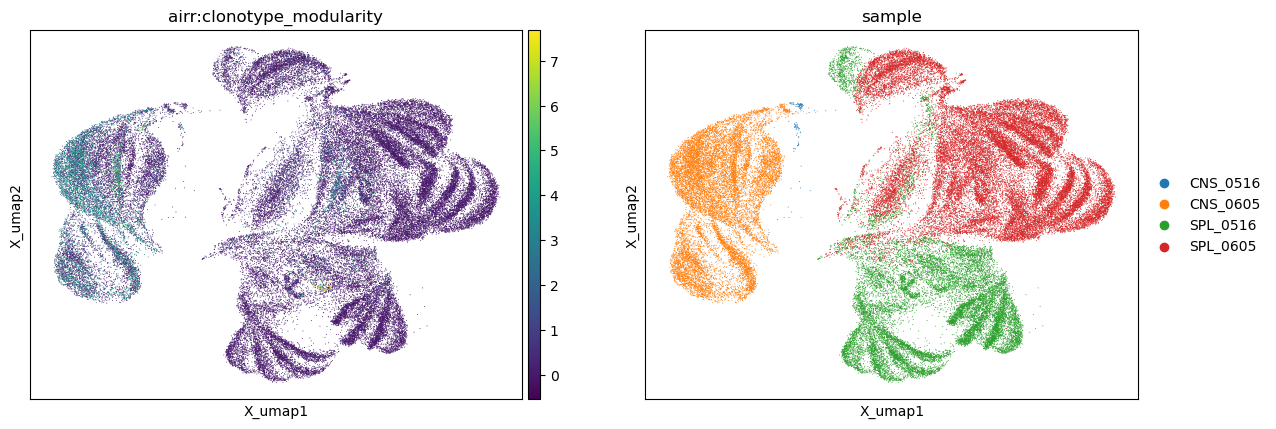

In [37]:
mu.pl.embedding(mdata, basis="gex:umap", color=["airr:clonotype_modularity","sample"])

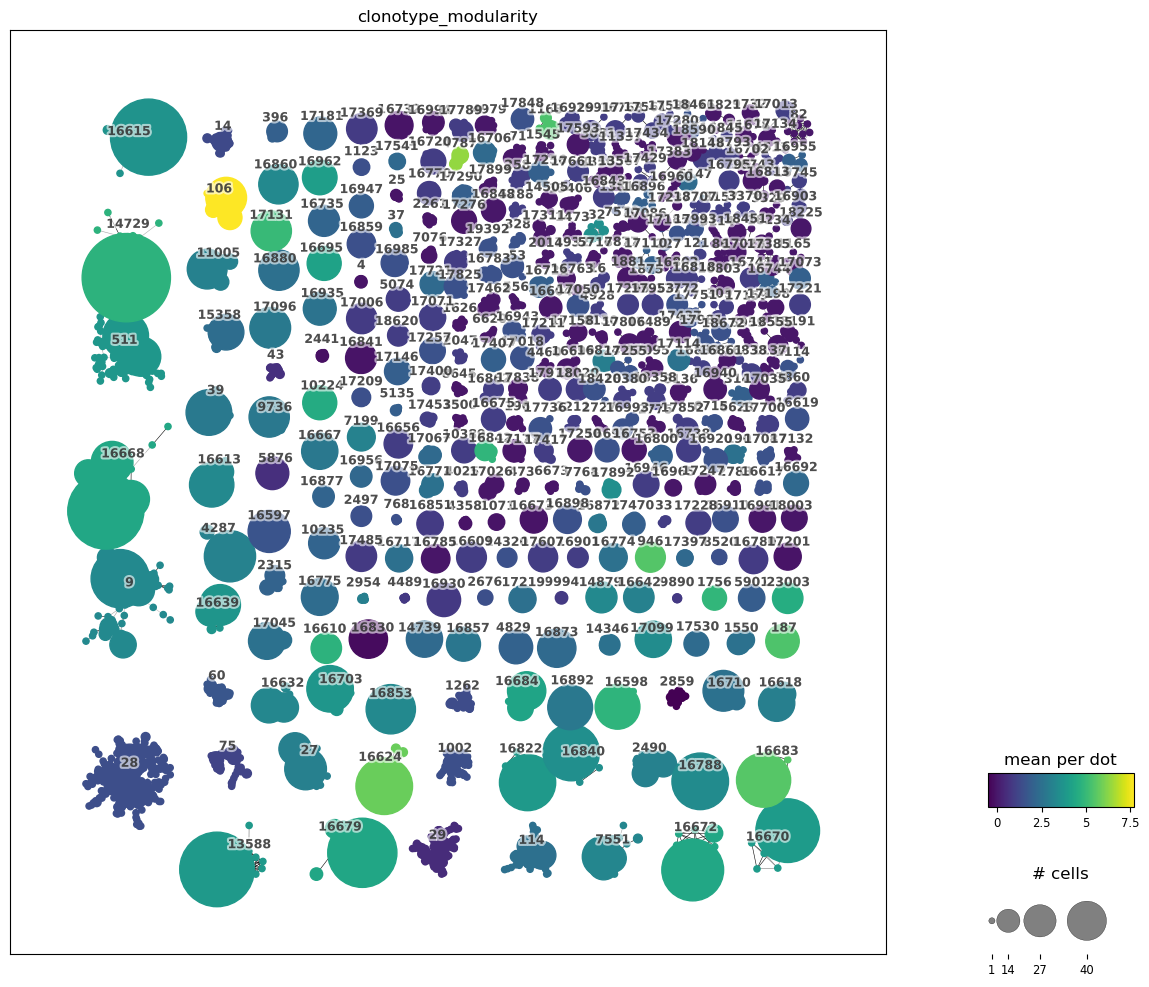

In [38]:
_ = ir.pl.clonotype_network(
    mdata,
    color="clonotype_modularity",
    label_fontsize=9,
    panel_size=(12, 12),
    base_size=20,
)


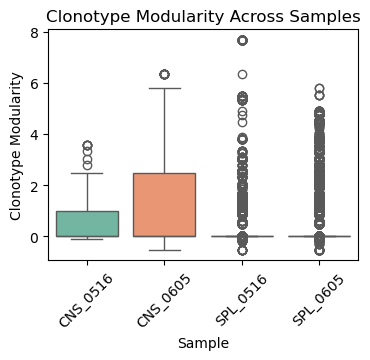

In [39]:
import seaborn as sns
import pandas as pd
mdata.obs["sample"] = mdata.obs["sample"].cat.remove_unused_categories()
# Extract relevant data from mdata_new
df_plot = mdata.obs[["airr:clonotype_modularity", "sample"]].dropna()

# Convert to DataFrame
df_plot = df_plot.astype({"airr:clonotype_modularity": float})

# Create the boxplot
plt.figure(figsize=(4, 3))
sns.boxplot(data=df_plot, x="sample", y="airr:clonotype_modularity", palette="Set2")

plt.xlabel("Sample")
plt.ylabel("Clonotype Modularity")
plt.title("Clonotype Modularity Across Samples")
plt.xticks(rotation=45)  # Rotate labels if needed
plt.show()

### Clonal expansion

CNS has a larger proportion of cells with ≥5 cells sharing the same clone compared to the spleen.

In [40]:
ir.tl.clonal_expansion(mdata)

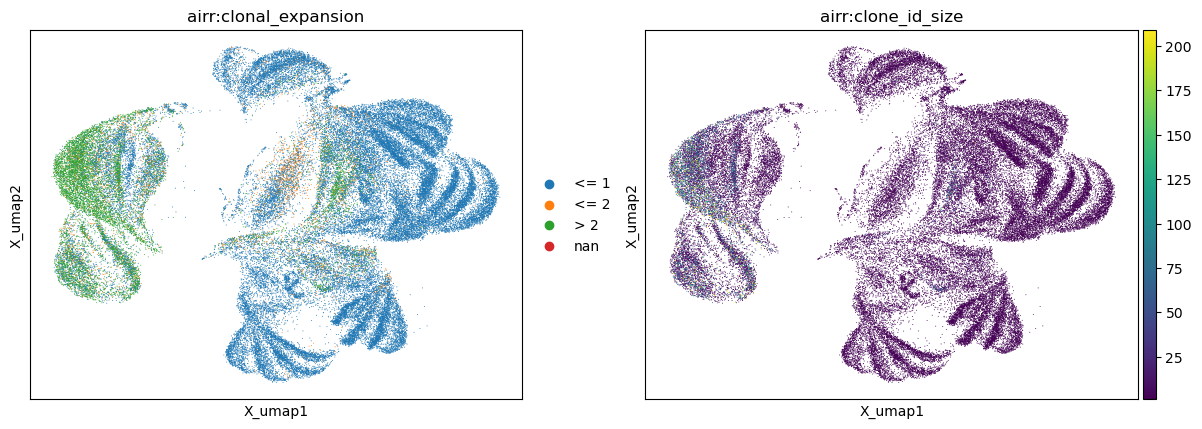

In [41]:
mu.pl.embedding(mdata, basis="gex:umap", color=["airr:clonal_expansion", "airr:clone_id_size"])

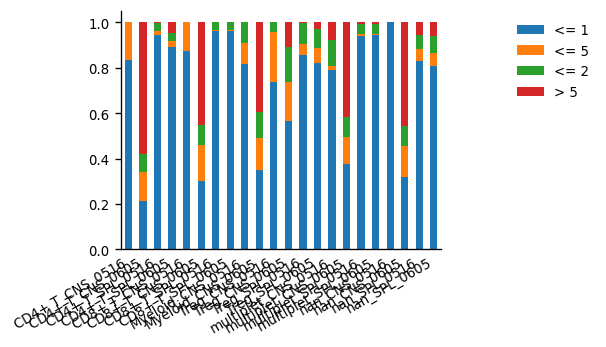

In [42]:
# Perform clonal expansion analysis
_ = ir.pl.clonal_expansion(
    mdata, 
    target_col="clone_id", 
    groupby="celltype_sample",  # Use the new combined column
    breakpoints=(1, 2, 5), 
    #normalize=False
)


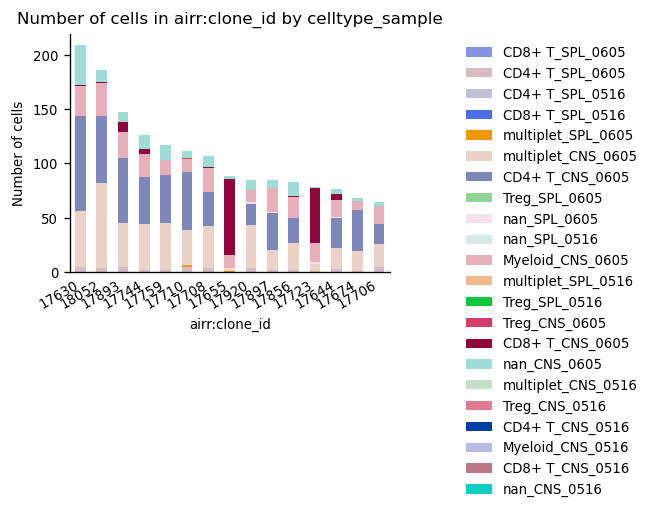

In [43]:
_ = ir.pl.group_abundance(
    mdata,
    groupby="airr:clone_id",
    target_col="celltype_sample",
    max_cols=15,
    #normalize="manual_cell_type",
)

### Motif

Slightly different motif for Treg_CNS_0605 cells and Treg_Spleen_0605 cells

In [44]:
mdata.obs["celltype_sample"].unique()

['Myeloid_CNS_0516', 'nan_CNS_0516', 'multiplet_CNS_0516', 'CD4+ T_CNS_0516', 'CD8+ T_CNS_0516', ..., 'Treg_SPL_0605', 'CD8+ T_SPL_0605', 'nan_SPL_0605', 'multiplet_SPL_0605', 'CD4+ T_SPL_0605']
Length: 22
Categories (22, object): ['CD4+ T_CNS_0516', 'CD4+ T_CNS_0605', 'CD4+ T_SPL_0516', 'CD4+ T_SPL_0605', ..., 'nan_CNS_0516', 'nan_CNS_0605', 'nan_SPL_0516', 'nan_SPL_0605']

In [45]:
ir.get.airr(mdata, "junction_aa", "VDJ_1")

cell_id
AAACGGAGTCTACGGA-1_0516_CNS        CGARETTETLYF
AAAGCGTAGGCAACGA-1_0516_CNS        CASGDGGREQYF
AACCACTCAATGGTCT-1_0516_CNS     CASSFGTGGYAEQFF
AACCAGACACGGCAAG-1_0516_CNS      CTCSAETASYEQYF
AAGGTGTAGCCCAACG-1_0516_CNS                None
                                     ...       
GTTGTGGGTGGAGCGA-1_0605_SPL        CGARDINERLFF
GTTGTGGGTGGATCGC-1_0605_SPL         CAWRVSTEVFF
GTTGTGGGTGGCTGTA-1_0605_SPL    CASSLDLGGDQDTQYF
GTTGTGGGTGTCCCTG-1_0605_SPL        CASGSKNTEVFF
GTTGTGGGTGTTACCC-1_0605_SPL        CASSLGQTEVFF
Length: 65203, dtype: object

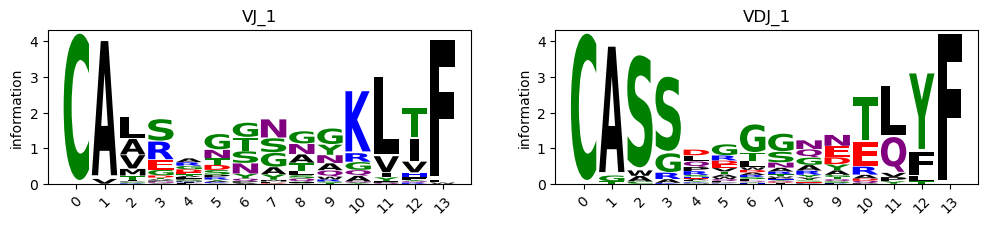

In [46]:
fix, axs = plt.subplots(1, 2, figsize=(12, 2))
for chain, ax in zip(["VJ_1", "VDJ_1"], axs, strict=False):
    ir.pl.logoplot_cdr3_motif(
        mdata[
            (mdata.obs["celltype_sample"] == "Treg_CNS_0605")
            & (ir.get.airr(mdata, "junction_aa", "VDJ_1").str.len() == 14)
            & (ir.get.airr(mdata, "junction_aa", "VJ_1").str.len() == 14)
        ],
        chains=chain,
        to_type="information",
        ax=ax,
    )

In [47]:
temp = mdata_filtered.obs["celltype_sample"] 
# == "Treg_Spleen_0605"
temp.value_counts()

celltype_sample
CD8+ T_SPL_0605       9638
CD4+ T_SPL_0605       9266
CD4+ T_SPL_0516       6022
CD8+ T_SPL_0516       4822
multiplet_CNS_0605    4393
multiplet_SPL_0605    3956
CD4+ T_CNS_0605       3590
Treg_SPL_0605         3084
nan_SPL_0605          3064
nan_SPL_0516          2876
Myeloid_CNS_0605      2401
Treg_SPL_0516         1803
multiplet_SPL_0516    1768
Treg_CNS_0605         1366
CD8+ T_CNS_0605       1176
nan_CNS_0605          1054
multiplet_CNS_0516      31
CD4+ T_CNS_0516         13
Treg_CNS_0516           11
Myeloid_CNS_0516         8
CD8+ T_CNS_0516          7
nan_CNS_0516             5
Name: count, dtype: int64

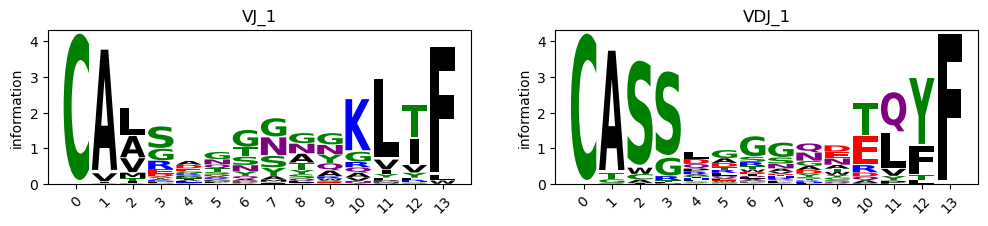

In [48]:
fix, axs = plt.subplots(1, 2, figsize=(12, 2))
for chain, ax in zip(["VJ_1", "VDJ_1"], axs, strict=False):
    ir.pl.logoplot_cdr3_motif(
        mdata_filtered[
            (mdata_filtered.obs["celltype_sample"] == "Treg_SPL_0605")
            & (ir.get.airr(mdata_filtered, "junction_aa", "VDJ_1").str.len() == 14)
            & (ir.get.airr(mdata_filtered, "junction_aa", "VJ_1").str.len() == 14)
        ],
        chains=chain,
        to_type="information",
        ax=ax,
    )

### DE analysis for high modularity clusters - mostly from CNS

In [49]:
clonotypes_top_modularity = list(
    mdata.obs.set_index("airr:cc_aa_tcrdist")["airr:clonotype_modularity"]
    .sort_values(ascending=False)
    .index.unique()
    .values[:10]
)


In [50]:
clonotypes_top_modularity #['107'-CD8_cns, '41'-CD8_cns, '287' - Treg_cns, '3' - CD4_cns, '9'-CD8_cns, '161'-CD8_cns, '49'-CD8_cns, '44'- CD4_cns, '3346'-Treg_spleen, '72'-CD4_cns]

['106',
 '4787',
 '16624',
 '16683',
 '946',
 '187',
 '1168',
 '17131',
 '1756',
 '16842']

In [54]:
# mdata.write("filtered_mdata.h5mu")

In [51]:
mdata.mod["airr"].obs["clonotype_modularity"].sort_values(ascending=False).index.unique().values[:10]

array(['CTAAGGTGTGGTTAGT-1_0516_SPL', 'CGGCTCCGTAACTTCT-1_0516_SPL',
       'CCCTAGACAAAATCCC-1_0516_SPL', 'CCATATTGTAGCCCTT-1_0516_SPL',
       'AAGCTTGTCCCCAATT-1_0516_SPL', 'CTGGGTTAGCAATTCG-1_0516_SPL',
       'CTGTTATGTGGGGAAT-1_0516_SPL', 'CCAGGGACACTGGAGG-1_0516_SPL',
       'CTGCGTACAGGATTAG-1_0516_SPL', 'CCGAATATCCATCTAC-1_0516_SPL'],
      dtype=object)

In [52]:
# List of clonotypes to analyze
clonotypes_top_modularity_for_CNS = ['1008', '38', '105', '604']

# Set up the context for ranking genes based on clonotype modularity
with ir.get.obs_context(mdata["gex"], {"cc_aa_tcrdist": mdata.obs["airr:cc_aa_tcrdist"]}) as tmp_ad:
    # Perform differential expression analysis using Wilcoxon test
    sc.tl.rank_genes_groups(
        tmp_ad,
        "cc_aa_tcrdist",
        groups=clonotypes_top_modularity_for_CNS,
        reference="rest",
        method="wilcoxon",
    )

    # Dynamically determine the number of rows/columns for subplots
    num_clonotypes = len(clonotypes_top_modularity_for_CNS)
    num_cols = 2  # Number of columns in the figure
    num_rows = int(np.ceil(num_clonotypes / num_cols))  # Number of rows based on total clonotypes

    # Create subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4))  
    axs = axs.flatten()  # Flatten in case of multiple rows

    # Generate violin plots for each clonotype
    for ct, ax in zip(clonotypes_top_modularity_for_CNS, axs):
        sc.pl.rank_genes_groups_violin(tmp_ad, groups=[ct], n_genes=15, ax=ax, show=False, strip=False)
        ax.set_title(f"Clonotype {ct}")  # Add title to each subplot

    # Remove any unused subplots
    for i in range(len(clonotypes_top_modularity_for_CNS), len(axs)):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.show()

ValueError: Could not calculate statistics for groups 1008, 38, 604 since they only contain one sample.